## Image Classification with Transfer Learning

This dataset from kaggle has been organized into 3 folders, train, validation and test. Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

In [23]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np
import glob
import sys, os, os.path
import seaborn as sns
import pandas as pd

Let's view an image of what a nomral chest would look like!

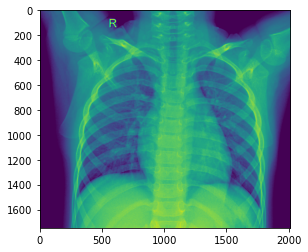

In [9]:
plt.imshow(image.imread('chest_xray/train/NORMAL/IM-0193-0001.jpeg'))

Now let's see what an image of a person with bacteria pneumonia would look like

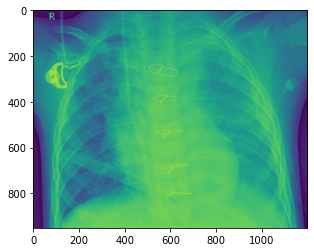

In [10]:
plt.imshow(image.imread('chest_xray/train/PNEUMONIA/person3_bacteria_11.jpeg'))

Now we take a look at the virus pneumonia chest X-ray image!

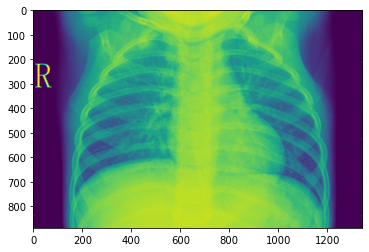

In [11]:
plt.imshow(image.imread('chest_xray/train/PNEUMONIA/person400_virus_794.jpeg'))

All three images seem rather similar. Some medical information found online states that a normal chest X-ray would depictsclear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia typically exhibits a focal lobar consolidation, whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs which can be seen in the image above.

There are different features within the nomal and pneumonia labelled images eventhough they are minute. Let us now count the images we have

In [3]:
num_normal = len(os.listdir('chest_xray/train/NORMAL'))
num_pneumonia = len(os.listdir('chest_xray/train/PNEUMONIA'))
print('The number of Normal chest X-rays are {}'.format(num_normal))
print('The number of Pnuemonia chest X-rays are {}'.format(num_pneumonia))

The number of Normal chest X-rays are 1341
The number of Pnuemonia chest X-rays are 3875


There are almost triple the number of Pnuemonia chest X-rays than normal chest X-ray images. In order for our model to be more accurate, we will need to deal with the imbalanced dataset and I will use image augmentation to oversample the minority class which is 'Normal'

I will write a function to oversample the minority class by flipping the image from a randomly selected image from the directory.

In [27]:
from PIL import ImageOps,Image
def mirror_data(minority_path,majority_path):
    '''
    This function accepts a path and will produce a mirror for each image. Will result in twice the number of original files
    '''
    file = os.listdir(minority_path)
    num_normal = len(os.listdir(minority_path))
    num_pneumonia = len(os.listdir(majority_path))
    number_to_mirror = num_pneumonia-num_normal
    
    if number_to_mirror == 0:
        print('Already balanced, quitting now')
        return   
    
    while number_to_mirror!=0:
        c = np.random.randint(0,num_normal)
        im = Image.open(minority_path+'/'+str(file[c]))
        new_image_path = minority_path +'/'+str(file[c]) + str(c) + '.jpeg'
        im_mirror = ImageOps.mirror(im)
        im_mirror.save(new_image_path)
        number_to_mirror = len(os.listdir(majority_path))-len(os.listdir(minority_path))
    
   
    print('Done mirroring images for:', minority_path)
    

mirror_data('chest_xray/train/NORMAL','chest_xray/train/PNEUMONIA')

Done mirroring images for: chest_xray/train/NORMAL


In [33]:
norm_len = len(os.listdir('chest_xray/train/NORMAL'))
pnuemonia_len = len(os.listdir('chest_xray/train/PNEUMONIA'))
print('The number of Normal chest X-rays are {}'.format(norm_len))
print('The number of Pnuemonia chest X-rays are {}'.format(pnuemonia_len))

The number of Normal chest X-rays are 3875
The number of Pnuemonia chest X-rays are 3875


Now that the data classes are balanced, we can proceed to create our model.

## Model Building

We will use a pre-trained model ResNet50 which has 48 Convolution layers along with 1 MaxPool and 1 Average Pool layer. The idea behind this is that features in images are hierachical, with models learning basic features like lines and strokes. With the pre-trained model that has weights already trained on the imagenet which consists of million of images with thousands of categories, our model training can be faster and more accurate. 

In [32]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


We will use the 'body' of the pre-trained model with the weights that have been trained and attach our own 'head' to customize the output which is 2 possible outputs of normal or pneumonia.

In [3]:
ptm = PretrainedModel(input_shape=[64,64,3],weights='imagenet',include_top=False)
ptm.trainable = False

In [4]:
x = Flatten()(ptm.output)
x = Dense(2,activation = 'softmax')(x)
model = Model(inputs=ptm.input,outputs=x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

#### Image Augmentation

By augmenting images, we will prevent overfitting which in turn will increase our model accuracy during evaluation on an unseen test set.

In [5]:
gen_train = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1, shear_range=0.1,zoom_range=0.2,horizontal_flip=True,preprocessing_function=preprocess_input)

In [6]:
gen_val = ImageDataGenerator(preprocessing_function=preprocess_input)


In [7]:
train_generator = gen_train.flow_from_directory('chest_xray/train',shuffle=True,target_size = (64,64))
valid_generator = gen_val.flow_from_directory('chest_xray/val',target_size=(64,64))


Found 6560 images belonging to 2 classes.
Found 1206 images belonging to 2 classes.


#### Fitting Model

Using the adam optimizer which is robust and has an adaptive learning rate. It can handle sparse gradients on noisy problems.

In [56]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
c = model.fit_generator(train_generator,validation_data=valid_generator,epochs=10,steps_per_epoch=int(np.ceil(6560/ 32)),validation_steps=int(np.ceil(1206/ 32)),verbose=1)

Epoch 1/10
205/205 [==============================] - 154s 733ms/step - loss: 0.5696 - accuracy: 0.9249 - val_loss: 0.3366 - val_accuracy: 0.9469
Epoch 2/10
205/205 [==============================] - 149s 726ms/step - loss: 0.5558 - accuracy: 0.9249 - val_loss: 0.5098 - val_accuracy: 0.9420
Epoch 3/10
205/205 [==============================] - 151s 736ms/step - loss: 0.4804 - accuracy: 0.9314 - val_loss: 0.3621 - val_accuracy: 0.9561
Epoch 4/10
205/205 [==============================] - 171s 836ms/step - loss: 0.5117 - accuracy: 0.9293 - val_loss: 1.4330 - val_accuracy: 0.8590
Epoch 5/10
205/205 [==============================] - 151s 738ms/step - loss: 0.5438 - accuracy: 0.9266 - val_loss: 1.4279 - val_accuracy: 0.8665
Epoch 6/10
205/205 [==============================] - 147s 718ms/step - loss: 0.4247 - accuracy: 0.9402 - val_loss: 0.4110 - val_accuracy: 0.9444
Epoch 7/10
205/205 [==============================] - 152s 740ms/step - loss: 0.4772 - accuracy: 0.9324 - val_loss: 1.2742 -

In [57]:
model.save('AutoDoc.h5')

In [8]:
from tensorflow.keras.models import load_model
model = load_model('AutoDoc.h5')

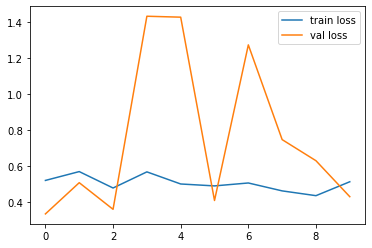

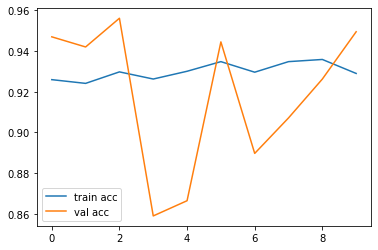

In [58]:
plt.plot(c.history['loss'], label='train loss')
plt.plot(c.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(c.history['accuracy'], label='train acc')
plt.plot(c.history['val_accuracy'], label='val acc')
plt.legend()


In [88]:

img_path = "chest_xray/test/NORMAL/IM-0001-0001.jpeg"
img = image.load_img(img_path, target_size=(64, 64))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
prediction = model.predict(img_preprocessed)
prediction[0][0]

1.0

In [47]:
test_norm = os.listdir('chest_xray/test/NORMAL')
test_pneumonia = os.listdir('chest_xray/test/PNEUMONIA')
Real = pd.DataFrame(test_norm,columns=['image'])
Real['class']= 0
Real2 = pd.DataFrame(test_pneumonia,columns=['image'])
Real2['class']=1
test_df = pd.concat([Real,Real2])
test_df = test_df.drop('image',axis=1)

In [36]:
lst_pred = []
for i in test_norm:
    img = image.load_img('chest_xray/test/NORMAL/'+str(i), target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)
    prediction = model.predict(img_preprocessed)
    if prediction[0][0]>=0.5:
        lst_pred.append(0)
    else:
        lst_pred.append(1)
len(lst_pred)

234

In [38]:
for i in test_pneumonia:
    img = image.load_img('chest_xray/test/PNEUMONIA/'+str(i), target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)
    prediction = model.predict(img_preprocessed)
    if prediction[0][0]>=0.5:
        lst_pred.append(0)
    else:
        lst_pred.append(1)
len(lst_pred)

624

In [49]:
predictions = test_df.drop('class',axis=1)
predictions['class'] = lst_pred
predictions

,class
0,0
1,0
2,0
3,0
4,0
...,...
385,1
386,1
387,1
388,1


In [50]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print(confusion_matrix(test_df,predictions))
print('\n')
print(classification_report(test_df,predictions))
print('\n')
print('Accuracy score {:.2f}'.format(accuracy_score(test_df,predictions)*100))


[[201  33]
 [ 42 348]]


              precision    recall  f1-score   support

           0       0.83      0.86      0.84       234
           1       0.91      0.89      0.90       390

    accuracy                           0.88       624
   macro avg       0.87      0.88      0.87       624
weighted avg       0.88      0.88      0.88       624



Accuracy score 87.98
